# Supplemental Information Section B - Analysis of library diversity

(c) 2017 the authors. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

In [1]:
import scipy.ndimage

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy as sp

# Import the project utils
import sys
sys.path.insert(0, '../code/')
import NB_sortseq_utils as utils

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.core.pylabtools import figsize

# Seaborn, useful for graphics
import seaborn as sns

sns.set_palette("deep", color_codes=True)
utils.set_plotting_style1()

%matplotlib inline

In [2]:
# load in library sequences 

mut_region_start = 0
mut_region_length = 70

data_fn = '../data/sortseq_pymc_dump/20150513_marR_MG1655_LB_na_mut1_4bins_seq.csv'

In [3]:
#======================================================#
# load sequences and convert to matrix representation
#======================================================#

f = open(data_fn)
roi_list = [(line.split(',')[0][mut_region_start:mut_region_start+mut_region_length], line.split(',')[1].strip()) for line in f if line.strip()]
f.close()    

# We only want unqiue sequences 
# read lines into one big list and transform into a set. This
# automatically gets rid of duplicate lines of sequences.
lines_unique = list(set(roi_list))
N = len(lines_unique)

# Convert each sequence into matrix representation
seq_mat = sp.zeros((4,mut_region_length,N),dtype=int)

for i, line in enumerate(lines_unique):
    seq_mat[:,:,i] = utils.seq2mat(line[0])

In [6]:
#======================================================#
# We also need to know what the wild-type sequence was
# to calculate number of mutations. Lets load those in.
#======================================================#

data_fn_wt = 'input_data/seq_WT_marmut1.txt'

seq_mat_wt = sp.zeros((4,mut_region_length,1),dtype=int)
seq_mat_wt_inv = sp.zeros((4,mut_region_length,1),dtype=int)

f = open(data_fn_wt)
for i, line in enumerate(f):
    if line.strip():
        sb = line.split(',')
        seq_mat_wt[:,:,i] = utils.seq2mat(sb[0][0:mut_region_length])
f.close()

# To determine whether a matrix has a mutation, I will
# multiply (inner product) it by an inverted wild-type 
# sequence (positions associated with wild-type sequence 
# have value 0, and 1 otherwise). The sum of this matrix
# product will give the number of mutations.
# Let's generate this inverted wild-type matrix.
for i in range(0,mut_region_length):
    for j in range(0,4):
        if seq_mat_wt[j,i] ==1:
            seq_mat_wt_inv[j,i] = 0
        else:
            seq_mat_wt_inv[j,i] = 1


In [7]:
#======================================================#
# calculate 'mutation' matrices
#======================================================#

seq_mat_mut = sp.zeros((4,mut_region_length,N),dtype=int)
for i in range(0,N):
    seq_mat_mut[:,:,i] = seq_mat[:,:,i] * seq_mat_wt_inv[:,:,0]


In [8]:
#======================================================#
# generate array to hold fraction of possible
# single, two-point, and three-point mutations.
#======================================================#

N_mut = sp.zeros(3,dtype=int)
N_possible = [(3*mut_region_length),
             (3*mut_region_length)*(3*(mut_region_length-1)),
             (3*mut_region_length)*(3*(mut_region_length-1))*(3*(mut_region_length-2))]
print(N_possible)


[210, 43470, 8867880]


In [9]:
#======================================================#
# Determine number of unique single point mutations
#======================================================#
seq_mat_mut_temp = seq_mat_mut.copy()
for i in range(0,N):
    # A matrix will sum to 1 if it has 1 mutations.
    # Use this to check number of sequences with 1 mutations
    if seq_mat_mut_temp[:,:,i].sum() != 1:
        seq_mat_mut_temp[:,:,i] = seq_mat_mut_temp[:,:,i]*0.0

# Calculate fraction of possible 1 point mutants    
N_mut[0] = seq_mat_mut_temp[:,:,:].sum()


In [10]:
#======================================================#
# Determine number of unique two point mutations
#======================================================#
seq_mat_mut_temp = seq_mat_mut.copy()
for i in range(0,N):
    # A matrix will sum to 2 if it has 2 mutations.
    # Use this to check number of sequences with 2 mutations
    if seq_mat_mut_temp[:,:,i].sum() != 2:
        seq_mat_mut_temp[:,:,i] = seq_mat_mut_temp[:,:,i]*0.0

# Divide by number of mutations, 2 (sum of each matrix will equal 2)        
N_mut[1] = seq_mat_mut_temp.sum()/2


In [11]:
#======================================================#
# Determine number of unique three point mutations
#======================================================#
seq_mat_mut_temp = seq_mat_mut.copy()
for i in range(0,N):
    # A matrix will sum to 3 if it has 3 mutations.
    # Use this to check number of sequences with 3 mutations
    if seq_mat_mut_temp[:,:,i].sum() != 3:
        seq_mat_mut_temp[:,:,i] = seq_mat_mut_temp[:,:,i]*0.0

# Divide by number of mutations, 3 (sum of each matrix will equal 3)    
N_mut[2] = seq_mat_mut_temp.sum()/3


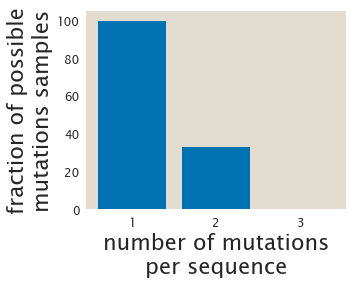

In [12]:
#======================================================#
# plot the result
#======================================================#
fig = plt.figure(1, figsize(5, 4))
ax = plt.subplot(111)             # the first subplot in the first figure
plt.bar(np.arange(1,4),100*N_mut/N_possible)#, width=0.015)
ax.set_xticks([1,2,3])
ax.set_ylabel('fraction of possible\nmutations samples')
ax.set_xlabel('number of mutations\nper sequence')
ax.grid(b=False)

plt.tight_layout()

figname_out = 'output_figs/figS1_fraction_possible_mutations.pdf'
fig.savefig(figname_out, format='pdf')